In [1]:
from __future__ import division, print_function
import numpy as np
from collections import OrderedDict
import logging

from IPython.display import display
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

from astropy.io import fits
import astropy.wcs
from astropy import coordinates
import astropy.units as apu
from astropy import table

import astropyp
from astropyp.wrappers.astromatic import ldac
from astropyp.phot import stack
import bd_search

alogger = logging.getLogger('astropyp')
alogger.setLevel(logging.INFO)

idx_connect = 'sqlite:////media/data-beta/users/fmooleka/decam/decam.db'
ref_path = '/media/data-beta/users/fmooleka/decam/catalogs/ref/'

# SExtractor 'extract' detection parameters
conv_filter = np.load('/media/data-beta/users/fmooleka/2016decam/5x5gauss.npy')
sex_params = {
    'extract': {
        'thresh': 40,
        #'err':,
        'minarea': 3, # default
        'conv': conv_filter,
        #'deblend_nthresh': 32, #default
        'deblend_cont': 0.001,
        #'clean': True, #default
        #'clean_param': 1 #default
    },
    'kron_k': 2.5,
    'kron_min_radius': 3.5,
    'filter': conv_filter,
    #'thresh': 1.5 # *bkg.globalrms
}

obj='F100'
refname = '2MASS'
#refname = 'UCAC4'
fullref = ldac.get_table_from_ldac(ref_path+'{0}-{1}.fits'.format(obj, refname))

In [2]:
import warnings
from astropy.utils.exceptions import AstropyWarning
warnings.simplefilter('ignore', category=AstropyWarning)

def get_exp_files(expnum, night, filtr, idx_connect):
    sql = 'select * from decam_obs where expnum={0} and filter like "{1}%" and dtcaldat="{2}"'.format(
        expnum, filtr, night)
    exp_info = astropyp.db_utils.index.query(sql, idx_connect)
    img_filename = exp_info[exp_info['PRODTYPE']=='image'][0]['filename']
    img = fits.open(img_filename)
    dqmask_filename = exp_info[exp_info['PRODTYPE']=='dqmask'][0]['filename']
    dqmask = fits.open(dqmask_filename)
    return img, dqmask
  
min_flux = 1000
min_amplitude = 1000
good_amplitude = 50
calibrate_amplitude = 200
frame = 1
#explist = [442430, 442431, 442432]
explist = [442433, 442434, 442435]
aper_radius = 8

ccds = OrderedDict()
good_indices = OrderedDict()
calibrate_indices = OrderedDict()

allwcs = OrderedDict()
imgs = []
dqmasks = []
for expnum in explist:
    #img, dqmask = get_exp_files(expnum, "2015-05-26", "i", idx_connect)
    img, dqmask = get_exp_files(expnum, "2015-05-26", "z", idx_connect)
    imgs.append(img[frame].data)
    header = img[frame].header
    wcs = astropy.wcs.WCS(header)
    img_data = img[frame].data
    dqmask_data = dqmask[frame].data
    dqmasks.append(dqmask_data)
    ccd = astropyp.phot.phot.SingleImage(header, img_data, dqmask_data,
        wcs=wcs, gain=4., exptime=30, aper_radius=aper_radius)
    ccd.detect_sources(sex_params, subtract_bkg=True, windowed=False)
    decam_flags = astropyp.phot.detect.get_img_flags(dqmask_data, ccd.catalog.x, ccd.catalog.y,
                (2*aper_radius+1, 2*aper_radius+1), edge_val=1)
    ccd.catalog.sources['flags'] = decam_flags
    ccd.select_psf_sources(min_flux,min_amplitude)
    ccd.create_psf()
    good_idx = (ccd.catalog.sources['pipeline_flags']==0)
    #ccd.perform_psf_photometry(indices=good_idx)
    ccds[expnum] = ccd
    good_indices[expnum] = good_idx & (ccd.catalog.sources['peak']>good_amplitude)
    calibrate_indices[expnum] = good_idx & (ccd.catalog.sources['peak']>calibrate_amplitude)
    alogger.info("Good sources: {0}".format(np.sum(good_indices[expnum])))
    alogger.info("Calibrate sources: {0}".format(np.sum(calibrate_indices[expnum])))
    allwcs[expnum] = wcs

INFO:astropyp.phot.psf:Total sources: 1099
INFO:astropyp.phot.psf:Sources with low flux: 0
INFO:astropyp.phot.psf:Sources with low amplitude: 757
INFO:astropyp.phot.psf:Sources with bad pixels: 205
INFO:astropyp.phot.psf:Elliptical sources: 81
INFO:astropyp.phot.psf:Source with close neighbors: 230
INFO:astropyp.phot.psf:Sources near an edge: 18
INFO:astropyp.phot.psf:Sources after cuts: 200
INFO:astropyp:Good sources: 687
INFO:astropyp:Calibrate sources: 509
INFO:astropyp.phot.psf:Total sources: 1024
INFO:astropyp.phot.psf:Sources with low flux: 0
INFO:astropyp.phot.psf:Sources with low amplitude: 733
INFO:astropyp.phot.psf:Sources with bad pixels: 181
INFO:astropyp.phot.psf:Elliptical sources: 72
INFO:astropyp.phot.psf:Source with close neighbors: 193
INFO:astropyp.phot.psf:Sources near an edge: 15
INFO:astropyp.phot.psf:Sources after cuts: 173
INFO:astropyp:Good sources: 658
INFO:astropyp:Calibrate sources: 478
INFO:astropyp.phot.psf:Total sources: 1134
INFO:astropyp.phot.psf:Source

In [4]:
from astropyp import astrometry
catalogs = [ccd.catalog.sources[calibrate_indices[expnum]] for expnum, ccd in ccds.items()]
catalogs = astropyp.catalog.match_all_catalogs(catalogs, 'ra','dec', combine=False)

transforms = OrderedDict()
pairs = [(0,1),(1,0),(1,2),(2,1)]
for pair in pairs:
    idx1,idx2 = pair
    transforms[pair] = astrometry.ImageSolution(order=1)
    transforms[pair].get_solution(catalogs[idx1], catalogs[idx2])
    print(pair, transforms[pair].stats)

(0, 1) {'rms': [0.099851245956758344, 0.097629656993243913], 'stddev': [0.099851245956758344, 0.097629656993243913], 'mean': [-1.3632453637540274e-12, 2.171576141632424e-12]}
(1, 0) {'rms': [0.099849912163565771, 0.097628988784096093], 'stddev': [0.099849912163565771, 0.097628988784096093], 'mean': [2.2487230780331642e-12, -8.487931323107079e-15]}
(1, 2) {'rms': [0.10343371193592317, 0.093857402194311088], 'stddev': [0.10343371193592318, 0.093857402194311088], 'mean': [1.7209280757599604e-12, -2.7929795228723937e-13]}
(2, 1) {'rms': [0.10342970807338657, 0.093860077693875124], 'stddev': [0.10342970807338657, 0.093860077693875124], 'mean': [1.0369422766395816e-12, 1.1939368548620508e-12]}


In [5]:
from astropyp.utils.misc import update_ma_idx

catalogs = [ccd.catalog.sources[good_indices[expnum]] for expnum, ccd in ccds.items()]

all_ra = [cat['ra'] for cat in catalogs]
all_dec = [cat['dec'] for cat in catalogs]
indices, matched = astropyp.catalog.get_merged_indices(all_ra, all_dec)

# Convert sources to x,y coordinates
x0,y0 = transforms[(0,1)].transform_coords(catalogs[0])
x2,y2 = transforms[(2,1)].transform_coords(catalogs[2])
all_x = [x0, catalogs[1]['x'], x2]
all_y = [y0, catalogs[1]['y'], y2]

# Match catalogs using their merged indices
tbl = table.Table(masked=True)
#all_x = [all_x[n][indices[n]] for n in range(len(catalogs))]
#all_y = [all_y[n][indices[n]] for n in range(len(catalogs))]
all_x = [update_ma_idx(all_x[n], indices[n]) for n in range(len(catalogs))]
all_y = [update_ma_idx(all_y[n], indices[n]) for n in range(len(catalogs))]

tbl['x'],tbl['y'] = astropyp.catalog.combine_coordinates(all_x, all_y, 'mean')

tbl['x0'] = all_x[0]
tbl['x1'] = all_x[1]
tbl['x2'] = all_x[2]
tbl['y0'] = all_y[0]
tbl['y1'] = all_y[1]
tbl['y2'] = all_y[2]

def stats(x1, y1, x2, y2):
    x_diff = x1-x2
    y_diff = y1-y2
    print('mean:',[np.mean(x_diff), np.mean(y_diff)])
    print('stddev:',[np.std(x_diff), np.std(y_diff)])

stats(tbl['x'], tbl['y'], tbl['x0'], tbl['y0'])
stats(tbl['x'], tbl['y'], tbl['x1'], tbl['y1'])
stats(tbl['x'], tbl['y'], tbl['x2'], tbl['y2'])

mean: [-0.0011358278358523273, -0.0038319183094148294]
stddev: [0.075645248639287371, 0.073170782876103901]
mean: [-0.0072529756119203087, 0.0076920899090988874]
stddev: [0.078600769770241566, 0.07212404443242558]
mean: [0.0080358490244098087, -0.0035150033019157203]
stddev: [0.073529612616370144, 0.074165209410707006]


peak 536.154846191


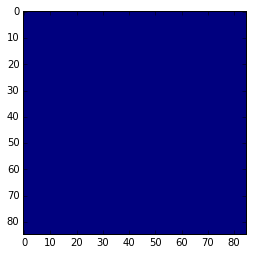

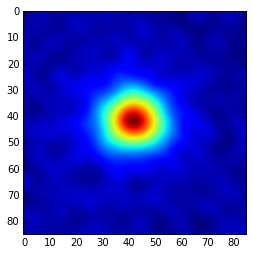

In [12]:
#src_idx = 0 # peak = 162
#src_idx = 2 # peak = 2000
#src_idx = 3 # peak = 11000
src_idx = 8 # peak = 536
#src_idx = 11 # peak = 267
#src_idx = 641 # peak=71
#src_idx = 471 # peak=99

print('peak', catalogs[0][indices[0]][src_idx]['peak'])

src = tbl[src_idx]
src_shape = (2*aper_radius+1, 2*aper_radius+1)
transforms[(1,1)] = None
tx_solutions = [transforms[(1,n)] for n in range(len(catalogs))]
data, dqmask = stack.stack_source(imgs, src['x'], src['y'], src_shape, 1, tx_solutions, 
                    dqmasks, combine_method='mean', show_plots=False)
plt.imshow(dqmask)
plt.show()
plt.imshow(data)
plt.show()

14.3271323324 1893.66775426
22.7628263257 1984.47376226
17.4997860032 1896.00906555


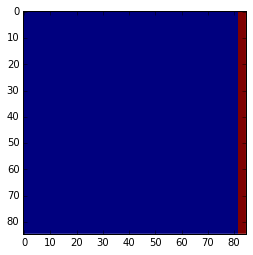

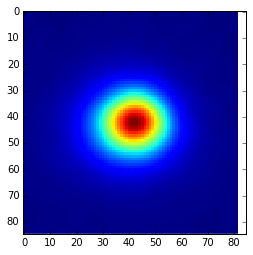

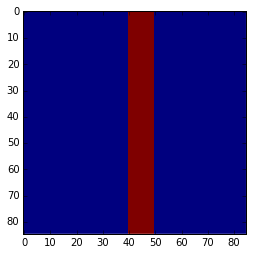

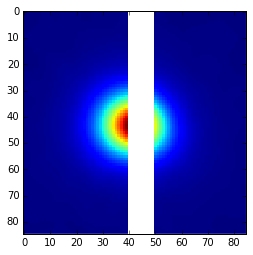

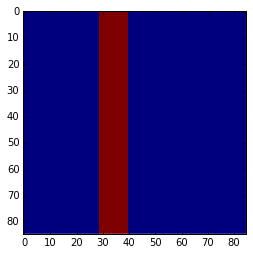

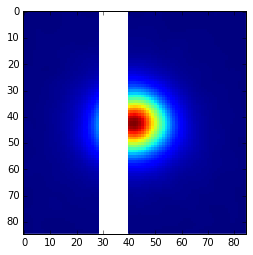

/media/data-beta/users/fmooleka/anaconda/envs/pyp27/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


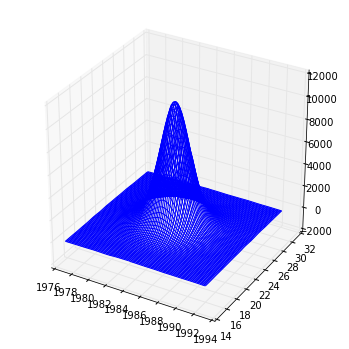

/media/data-beta/users/fmooleka/anaconda/envs/pyp27/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):


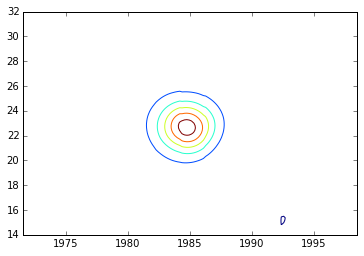

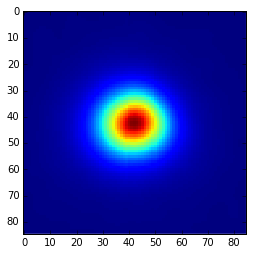

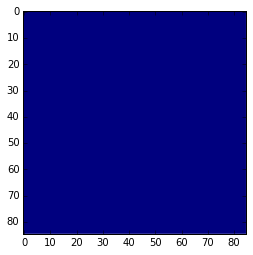

In [7]:
cat0 = ccds[442433].catalog.sources
cat1 = ccds[442434].catalog.sources
cat2 = ccds[442435].catalog.sources

#src0 = cat0[cat0['pipeline_flags']>=128][6]
src0 = cat0[cat0['pipeline_flags']>=128][3]
print(src0['y'], src0['x'])

c0 = coordinates.SkyCoord([src0['ra']],[src0['dec']], unit='deg')
c1 = coordinates.SkyCoord(cat1['ra'],cat1['dec'], unit='deg')
c2 = coordinates.SkyCoord(cat2['ra'],cat2['dec'], unit='deg')

idx1, d2, d3 = c0.match_to_catalog_sky(c1)
idx1 = idx1[0]
idx2, d2, d3 = c0.match_to_catalog_sky(c2)
idx2 = idx2[0]

# Get the patch from the original image
src1 = cat1[idx1]
src2 = cat2[idx2]
print(src1['y'],src1['x'])
print(src2['y'],src2['x'])

src_shape = (2*aper_radius+1, 2*aper_radius+1)
data, dqmask = stack.stack_source(imgs, src1['x'], src1['y'], src_shape, 1, tx_solutions, 
                    dqmasks, combine_method='mean', show_plots=True)

9.09027241105 886.177722661
8.72229524991 879.355114191
10.949032189 888.510324119


/media/data-beta/users/fmooleka/git_projects/astropyp/astropyp/utils/misc.py:217: UserWarning: The patch for the source at [   8.72229525  879.35511419] contains NaN values, cannot interpolate
  warnings.warn(w)


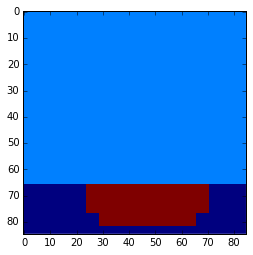

/media/data-beta/users/fmooleka/git_projects/astropyp/astropyp/utils/misc.py:217: UserWarning: The patch for the source at [   9.47949143  886.20240993] contains NaN values, cannot interpolate
  warnings.warn(w)


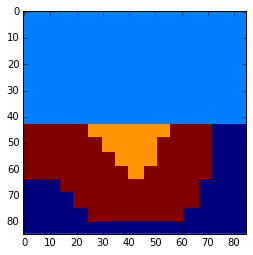

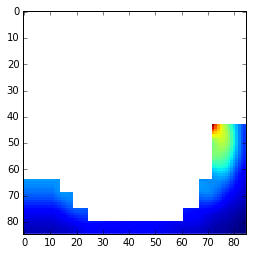

In [9]:
cat0 = ccds[442433].catalog.sources
cat1 = ccds[442434].catalog.sources
cat2 = ccds[442435].catalog.sources

src0 = cat0[cat0['pipeline_flags']>=128][6]
#src0 = cat0[cat0['pipeline_flags']>=128][3]
print(src0['y'], src0['x'])

c0 = coordinates.SkyCoord([src0['ra']],[src0['dec']], unit='deg')
c1 = coordinates.SkyCoord(cat1['ra'],cat1['dec'], unit='deg')
c2 = coordinates.SkyCoord(cat2['ra'],cat2['dec'], unit='deg')

idx1, d2, d3 = c0.match_to_catalog_sky(c1)
idx1 = idx1[0]
idx2, d2, d3 = c0.match_to_catalog_sky(c2)
idx2 = idx2[0]

# Get the patch from the original image
src1 = cat1[idx1]
src2 = cat2[idx2]
print(src1['y'],src1['x'])
print(src2['y'],src2['x'])

src_shape = (2*aper_radius+1, 2*aper_radius+1)
data, dqmask = stack.stack_source(imgs, src1['x'], src1['y'], src_shape, 1, tx_solutions, 
                    dqmasks, combine_method='mean', show_plots=True)

5.9980327984 1660.96286615
5.40439314685 1654.13225197
9.00962861809 1663.42518353


/media/data-beta/users/fmooleka/git_projects/astropyp/astropyp/utils/misc.py:217: UserWarning: The patch for the source at [    5.40439315  1654.13225197] contains NaN values, cannot interpolate
  warnings.warn(w)


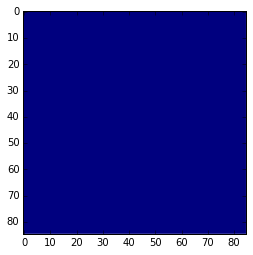

None None


/media/data-beta/users/fmooleka/git_projects/astropyp/astropyp/utils/misc.py:217: UserWarning: The patch for the source at [    6.16539158  1660.96691077] contains NaN values, cannot interpolate
  warnings.warn(w)
/media/data-beta/users/fmooleka/git_projects/astropyp/astropyp/utils/misc.py:217: UserWarning: The patch for the source at [    9.58952936  1663.22507723] contains NaN values, cannot interpolate
  warnings.warn(w)


In [10]:
cat0 = ccds[442433].catalog.sources
cat1 = ccds[442434].catalog.sources
cat2 = ccds[442435].catalog.sources

src0 = cat0[cat0['pipeline_flags']>=128][0]
print(src0['y'], src0['x'])

c0 = coordinates.SkyCoord([src0['ra']],[src0['dec']], unit='deg')
c1 = coordinates.SkyCoord(cat1['ra'],cat1['dec'], unit='deg')
c2 = coordinates.SkyCoord(cat2['ra'],cat2['dec'], unit='deg')

idx1, d2, d3 = c0.match_to_catalog_sky(c1)
idx1 = idx1[0]
idx2, d2, d3 = c0.match_to_catalog_sky(c2)
idx2 = idx2[0]

# Get the patch from the original image
src1 = cat1[idx1]
src2 = cat2[idx2]
print(src1['y'],src1['x'])
print(src2['y'],src2['x'])

src_shape = (2*aper_radius+1, 2*aper_radius+1)
data, dqmask = stack.stack_source(imgs, src1['x'], src1['y'], src_shape, 1, tx_solutions, 
                    dqmasks, combine_method='mean', show_plots=True)
print(data, dqmask)

In [43]:
all_ra = [cat1['ra_win'], cat2['ra_win'], cat3['ra_win']]
all_dec = [cat1['dec_win'], cat2['dec_win'], cat3['dec_win']]
ra, dec = astropyp.catalog.combine_coordinates(all_ra, all_dec, method='median')
cc = table.Table([ra, dec, cat1['xwin'], cat1['ywin'], cat1['peak']], names=('ra','dec','x','y', 'peak'))

good_cat = astropyp.catalog.Catalog(cc)
refcat = astropyp.catalog.Catalog(fullref)
metric = astropyp.astrometry.AstrometricSolution()

ref_weights = 1/np.sqrt(refcat.e_ra**2+refcat.e_dec**2)

idx, matched = metric.get_solution(good_cat, refcat, ref_weights=ref_weights)
#idx, matched = metric.get_solution(good_cat, refcat, separation=3*apu.arcsec)

ra,dec = metric.pix2world(good_cat.x[matched],good_cat.y[matched])
d_ra = ((np.abs(ra-np.array(refcat.ra[idx][matched]))*np.cos(np.deg2rad(np.array(dec))))*apu.deg).to('mas')
d_dec = ((np.abs(dec-np.array(refcat.dec[idx][matched])))*apu.deg).to('mas')
print 'mean d_ra', np.mean(d_ra)
print 'mean d_dec', np.mean(d_dec)
print 'ra rms', np.sqrt(np.sum(d_ra**2)/d_ra.shape[0])
print 'dec rms', np.sqrt(np.sum(d_dec**2)/d_dec.shape[0])

c1 = coordinates.SkyCoord(ra, dec, unit='deg')
c2 = coordinates.SkyCoord(refcat.ra[idx][matched], refcat.dec[idx][matched], unit='deg')
separation = c1.separation(c2)
separation = separation.to('arcsec')
print np.mean(separation)
print np.std(separation)
print 'rms', np.sqrt(np.sum(separation**2)/separation.shape[0])

pidx = good_cat['peak'][matched]>1000
c1 = coordinates.SkyCoord(ra[pidx], dec[pidx], unit='deg')
c2 = coordinates.SkyCoord(refcat.ra[idx][matched][pidx], refcat.dec[idx][matched][pidx], unit='deg')
separation = c1.separation(c2)
separation = separation.to('arcsec')
print 'high SNR sources', np.sum(pidx)
print 'high SNR', np.mean(separation)
print 'high SNR', np.std(separation)
print 'high SNR rms', np.sqrt(np.sum(separation**2)/separation.shape[0])

x,y = metric.world2pix(ra, dec)
d2 = np.sqrt((x-good_cat.x[matched])**2 + (y-good_cat.y[matched])**2)
print 'cartesian mean', np.mean(d2)
print 'cartesian stddev', np.std(d2)
print 'cartesian rms', np.mean(d2)+np.std(d2)

INFO:astropyp.astrometry:formula: "ra ~ A_1_0+A_0_1+A_2_0+A_1_1+A_0_2+A_3_0+A_2_1+A_1_2+A_0_3"
INFO:astropyp.astrometry:formula: "dec ~ B_1_0+B_0_1+B_2_0+B_1_1+B_0_2+B_3_0+B_2_1+B_1_2+B_0_3"
INFO:astropyp.astrometry:formula: "x ~ Ap_1_0+Ap_0_1+Ap_2_0+Ap_1_1+Ap_0_2+Ap_3_0+Ap_2_1+Ap_1_2+Ap_0_3"
INFO:astropyp.astrometry:formula: "y ~ Bp_1_0+Bp_0_1+Bp_2_0+Bp_1_1+Bp_0_2+Bp_3_0+Bp_2_1+Bp_1_2+Bp_0_3"


mean d_ra 148.273333735 mas
mean d_dec 164.221127466 mas
ra rms 207.638633338 mas
dec rms 232.602229007 mas
0.245495arcsec
0.192224arcsec
rms 0.311797490127 arcsec
high SNR sources 163
high SNR 0.218024arcsec
high SNR 0.169536arcsec
high SNR rms 0.276182387981 arcsec
cartesian mean 0.0815204269474
cartesian stddev 0.0550560115865
cartesian rms 0.136576438534


In [31]:
good_cat = astropyp.catalog.Catalog(cat1, ra='ra_win', dec='dec_win', x='xwin',y='ywin')
refcat = astropyp.catalog.Catalog(fullref)
metric = astropyp.astrometry.AstrometricSolution()

ref_weights = 1/np.sqrt(refcat.e_ra**2+refcat.e_dec**2)

idx, matched = metric.get_solution(good_cat, refcat, ref_weights=ref_weights)
#idx, matched = metric.get_solution(good_cat, refcat, separation=3*apu.arcsec)

ra,dec = metric.pix2world(good_cat.x[matched],good_cat.y[matched])

c1 = coordinates.SkyCoord(ra, dec, unit='deg')
c2 = coordinates.SkyCoord(refcat.ra[idx][matched], refcat.dec[idx][matched], unit='deg')
separation = c1.separation(c2)
separation = separation.to('arcsec')
print np.mean(separation)
print np.std(separation)
print 'rms', np.sqrt(np.sum(separation**2)/separation.shape[0])

#pidx = good_cat['peak'][matched]>2000
pidx = good_cat['aper_flux'][matched]/good_cat['aper_flux_err'][matched]>100
c1 = coordinates.SkyCoord(ra[pidx], dec[pidx], unit='deg')
c2 = coordinates.SkyCoord(refcat.ra[idx][matched][pidx], refcat.dec[idx][matched][pidx], unit='deg')
separation = c1.separation(c2)
separation = separation.to('arcsec')
print 'high SNR sources', np.sum(pidx)
print 'high SNR', np.mean(separation)
print 'high SNR', np.std(separation)
print 'high SNR rms', np.sqrt(np.sum(separation**2)/separation.shape[0])

x,y = metric.world2pix(ra, dec)
d2 = np.sqrt((x-good_cat.x[matched])**2 + (y-good_cat.y[matched])**2)
print 'cartesian mean', np.mean(d2)
print 'cartesian stddev', np.std(d2)
print 'cartesian rms', np.sqrt(np.sum(d2**2)/d2.shape[0])

INFO:astropyp.astrometry:formula: "ra ~ A_1_0+A_0_1+A_2_0+A_1_1+A_0_2+A_3_0+A_2_1+A_1_2+A_0_3"
INFO:astropyp.astrometry:formula: "dec ~ B_1_0+B_0_1+B_2_0+B_1_1+B_0_2+B_3_0+B_2_1+B_1_2+B_0_3"
INFO:astropyp.astrometry:formula: "x ~ Ap_1_0+Ap_0_1+Ap_2_0+Ap_1_1+Ap_0_2+Ap_3_0+Ap_2_1+Ap_1_2+Ap_0_3"
INFO:astropyp.astrometry:formula: "y ~ Bp_1_0+Bp_0_1+Bp_2_0+Bp_1_1+Bp_0_2+Bp_3_0+Bp_2_1+Bp_1_2+Bp_0_3"


0.245495arcsec
0.192224arcsec
rms 0.311797490127 arcsec
high SNR sources 193
high SNR 0.245495arcsec
high SNR 0.192224arcsec
high SNR rms 0.311797490127 arcsec
cartesian mean 0.0815204269474
cartesian stddev 0.0550560115865
cartesian rms 0.0983704448577


In [34]:
referr = np.sqrt(fullref['e_ra']**2 + fullref['e_dec']**2)
print np.mean(referr)
print np.std(referr)
print np.sqrt(np.sum(referr**2)/referr.shape[0])

211.415487967 mas
108.953537473 mas
237.838983096 mas


In [35]:
pidx = good_cat['aper_flux'][matched]/good_cat['aper_flux_err'][matched]>100
c1 = coordinates.SkyCoord(good_cat['ra'][matched][pidx], good_cat['dec'][matched][pidx], unit='deg')
c2 = coordinates.SkyCoord(refcat.ra[idx][matched][pidx], refcat.dec[idx][matched][pidx], unit='deg')
separation = c1.separation(c2)
separation = separation.to('arcsec')
print 'high SNR sources', np.sum(pidx)
print 'high SNR', np.mean(separation)
print 'high SNR', np.std(separation)
print 'high SNR rms', np.sqrt(np.sum(separation**2)/separation.shape[0])

high SNR sources 193
high SNR 0.259725arcsec
high SNR 0.201557arcsec
high SNR rms 0.328758633106 arcsec


In [47]:
sql = 'select * from decam_obs where expnum={0}'.format(206392)
astropyp.db_utils.index.query(sql, idx_connect)

id,EXPNUM,EXPTIME,DATE-OBS,MJD-OBS,OBS-LAT,OBS-LONG,OBSTYPE,PROPID,RA,DEC,FILTER,OBJECT,DTCALDAT,filename,PROCTYPE,PRODTYPE,ZD,AIRMASS
int64,int64,float64,str26,float64,str9,str8,str6,str10,str11,str10,str32,str18,str10,str68,str7,str6,float64,float64
75,206392,15.0,2013-05-29T23:38:03.560666,56441.9847634,-30.16606,70.81489,object,2013A-0723,14:42:00.32,-0:04:48.4,z DECam SDSS c0004 9260.0 1520.0,SDSSJ1442-0000-z15,2013-05-29,/media/data-beta/decam/2013A-0723/c4d_130529_233803_ood_z_v1.fits.fz,InstCal,dqmask,55.67,1.7731800693
474,206392,15.0,2013-05-29T23:38:03.560666,56441.9847634,-30.16606,70.81489,object,2013A-0723,14:42:00.32,-0:04:48.4,z DECam SDSS c0004 9260.0 1520.0,SDSSJ1442-0000-z15,2013-05-29,/media/data-beta/decam/2013A-0723/c4d_130529_233803_ooi_z_v1.fits.fz,InstCal,image,55.67,1.7731800693
1024,206392,15.0,2013-05-29T23:38:03.560666,56441.9847634,-30.16606,70.81489,object,2013A-0723,14:42:00.32,-0:04:48.4,z DECam SDSS c0004 9260.0 1520.0,SDSSJ1442-0000-z15,2013-05-29,/media/data-beta/decam/2013A-0723/c4d_130529_233803_oow_z_v1.fits.fz,InstCal,wtmap,55.67,1.7731800693
